# Lab13-2 Image Captioning
110065508 李丞恩

In [1]:
# HYPER_PARAMETERS
INPUT_SHAPE_W = 224 # input shape = (batch_size, 224, 448, 3)
INPUT_SHAPE_H = 448
BATCH_SIZE = 50
BUFFER_SIZE = 5000
embedding_dim = 128
units = 64
vocab_size = 29 #a~z & <start> & <end> & <pad>
max_length = 7
annotation_file = "./words_captcha/spec_train_val.txt"

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import re
import numpy as np
import os
import time
import json
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape, Dense

## 一. 讀取dataset

In [3]:
all_captions = [] # Store captions and image names in vectors
all_img_name_vector = []

file = open(annotation_file, "r")
for line in file:
    temp = line.strip('\n').split(' ')
    all_img_name_vector.append("words_captcha" + "/" + temp[0] + ".png")
    all_captions.append(temp[1])

先拆成training set跟validation set。

In [4]:
# Create training and validation sets using an 100000-20000 split
img_path_train, img_path_val, captions_train, captions_val = \
    train_test_split(all_img_name_vector, all_captions, test_size=20000,random_state=0)

In [5]:
num_steps = len(img_path_train) // BATCH_SIZE #取整除

In [6]:
len(img_path_train), len(img_path_val), len(captions_train), len(captions_val)

(100000, 20000, 100000, 20000)

接著要定義每個英文字母以及特殊字元的mapping。

In [7]:
# Load the numpy files
def map_func(img_path, captions):
    # load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    img = img / 255.0
    img = tf.image.resize(img, (INPUT_SHAPE_W, INPUT_SHAPE_H))
    
    # process caption
    cap = []
    cap.append(27) # start = 27
    for i in range(6):
        number = 0 # empty = 0
        if i < len(captions):
            number = (captions[i]) - 96
        elif i == len(captions):
            number = 28

        cap.append(np.int64(number))
    
    return img, cap

然後生成training要用的dataset。

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((img_path_train, captions_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 二. Model與Encoder-Decoder設計

### 1. Attention機制

In [9]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 2. CNN Encoder
原本我是用助教在lab的網頁放的CNN作為架構，結果發現效果很差。結果底下這個架構也train不起來= =

In [10]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        
        self.conv1_1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv1_2 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')
        self.pool1   = MaxPool2D(pool_size=(2, 2), strides=(2, 2))

        self.conv2_1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv2_2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.pool2   = MaxPool2D(pool_size=(2, 2), strides=(2, 2))

        self.conv3_1 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv3_2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')
        self.pool3   = MaxPool2D(pool_size=(2, 2), strides=(2, 2))

        self.conv4_1 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv4_2 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')
        self.pool4   = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        
        self.conv5_1 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')
        self.pool5   = MaxPool2D(pool_size=(2, 2), strides=(2, 2))

        self.reshape = Reshape((-1, 256))
        self.dense1 = Dense(192, activation='relu')
        self.dense2 = Dense(embedding_dim, activation='relu')

    def call(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.pool4(x)
        
        x = self.conv5_1(x)
        x = self.pool5(x)

        x = self.reshape(x)
        
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

### 3. RNN Decoder
直接使用助教提供的RNN作為decoder。

In [11]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### 4. loss_function

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 5. 將Model組合

In [13]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### 三. 訓練Model

### 1. 設定checkpoint

In [14]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [15]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

### 2. 定義訓練函式

In [16]:
@tf.function
def train_step(img, target):
    loss = 0
             
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([27] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:  
                                
        features = encoder(img)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    ## 平均每個字預測的cross entrophy
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### 3. 開始訓練

In [17]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [18]:
loss_plot = []

EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.793332
Time taken for 1 epoch 894.2071969509125 sec

Epoch 2 Loss 1.584647
Time taken for 1 epoch 825.0941240787506 sec

Epoch 3 Loss 1.542179
Time taken for 1 epoch 817.0373728275299 sec

Epoch 4 Loss 1.513441
Time taken for 1 epoch 822.4761118888855 sec

Epoch 5 Loss 1.489676
Time taken for 1 epoch 805.4343481063843 sec

Epoch 6 Loss 1.468274
Time taken for 1 epoch 802.2388122081757 sec

Epoch 7 Loss 1.448043
Time taken for 1 epoch 803.4625358581543 sec

Epoch 8 Loss 1.429753
Time taken for 1 epoch 803.132639169693 sec

Epoch 9 Loss 1.413787
Time taken for 1 epoch 812.6498885154724 sec

Epoch 10 Loss 1.399863
Time taken for 1 epoch 853.1010134220123 sec

Epoch 11 Loss 1.386701
Time taken for 1 epoch 882.2529292106628 sec

Epoch 12 Loss 1.376707
Time taken for 1 epoch 863.33291888237 sec

Epoch 13 Loss 1.366632
Time taken for 1 epoch 826.8417088985443 sec

Epoch 14 Loss 1.357598
Time taken for 1 epoch 817.572124004364 sec

Epoch 15 Loss 1.348387
Time taken for 1 epoch 8

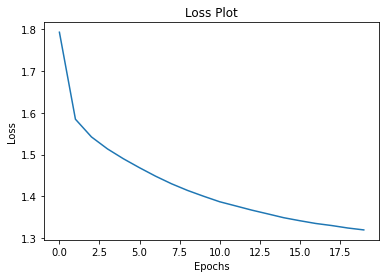

In [19]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 四. 結果檢驗
### 1. 計算正確率

In [20]:
def evaluate(img_path):
    # load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    img = img / 255.0
    img = tf.image.resize(img, (INPUT_SHAPE_W, INPUT_SHAPE_H))
    img = tf.expand_dims(img, 0)
    
    hidden = decoder.reset_state(batch_size = 1)
    features = encoder(img)
    dec_input = tf.expand_dims([27], 0)
    result = ""
    
    for i in range(1, max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        if predicted_id >= 1 and predicted_id <= 26:
            result = result + chr(predicted_id + 96)

        if predicted_id == 28:
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [21]:
match = 0
for (index, img_path) in enumerate(img_path_val):
    predict = evaluate(img_path)
    if predict == captions_val[index]:
        match = match + 1
    else:
        print(predict, captions_val[index])

stat log
stat rays
stat cos
stat italy
stat wake
stat bands
stat miss
stat vcr
stat take
stat spent
stat makes
stat ghost
stat rss
stat gun
stat limit
stat nhs
stat walt
stat fat
stat yoga
stat dis
stat clip
stat ford
stat tank
stat odds
stat tax
stat dan
stat poll
stat phd
stat mas
stat flat
stat room
stat leave
stat five
stat bird
stat gold
stat tube
stat doubt
stat code
stat ruth
stat range
stat deer
stat plate
stat laura
stat daily
stat zen
stat types
stat shoes
stat cad
stat del
stat goods
stat sit
stat trail
stat east
stat key
stat solid
stat taxi
stat their
stat kim
stat sig
stat silk
stat owned
stat ins
stat fax
stat phase
stat ships
stat cnn
stat burn
stat dicke
stat cnn
stat equal
stat tag
stat pump
stat white
stat name
stat hash
stat tools
stat char
stat hook
stat bean
stat ppc
stat until
stat buddy
stat apps
stat plus
stat rats
stat tale
stat sale
stat tar
stat boost
stat ion
stat rca
stat lewis
stat tile
stat lead
stat were
stat world
stat rosa
stat ours
stat aim
stat wayn

stat goat
stat child
stat linux
stat linda
stat urge
stat buyer
stat tips
stat ate
stat allow
stat kyle
stat mars
stat extra
stat alto
stat eyed
stat via
stat lean
stat magic
stat cells
stat gcc
stat terry
stat kiss
stat end
stat speed
stat hate
stat wild
stat pot
stat dust
stat war
stat clubs
stat blah
stat send
stat music
stat ada
stat grid
stat josh
stat vote
stat neil
stat sons
stat eve
stat stats
stat comes
stat drama
stat vary
stat gives
stat pct
stat suit
stat want
stat ann
stat avoid
stat value
stat picks
stat taxi
stat final
stat stage
stat one
stat power
stat san
stat walt
stat human
stat rice
stat oral
stat mile
stat oct
stat neck
stat utc
stat alt
stat lid
stat role
stat size
stat ati
stat beast
stat dam
stat self
stat gui
stat eco
stat zen
stat fee
stat hills
stat adds
stat rear
stat lucky
stat wish
stat moral
stat ripe
stat mild
stat walk
stat say
stat mouse
stat shot
stat ever
stat love
stat sip
stat exam
stat lay
stat moon
stat query
stat add
stat phys
stat world
stat m

stat burn
stat intl
stat muze
stat began
stat shoes
stat jam
stat louis
stat jade
stat louis
stat scene
stat guys
stat anna
stat task
stat burn
stat usda
stat adult
stat ever
stat luck
stat shop
stat pub
stat save
stat burn
stat allow
stat army
stat ryan
stat mall
stat pie
stat hiv
stat grade
stat rate
stat lace
stat joel
stat acre
stat trips
stat greg
stat fresh
stat happy
stat him
stat virus
stat pro
stat fell
stat calls
stat wolf
stat asia
stat mere
stat warm
stat eagle
stat fill
stat than
stat hugh
stat tap
stat happy
stat coach
stat bean
stat row
stat usage
stat navy
stat fun
stat faces
stat ing
stat shoe
stat dodge
stat pic
stat msg
stat rear
stat ship
stat dow
stat non
stat rock
stat bill
stat bios
stat why
stat back
stat solar
stat baker
stat wma
stat makes
stat pride
stat den
stat hats
stat say
stat ink
stat begin
stat one
stat gis
stat boot
stat again
stat grove
stat seal
stat see
stat mpeg
stat march
stat beat
stat plc
stat most
stat its
stat pets
stat head
stat pale
stat fo

stat dvd
stat matt
stat event
stat total
stat hunt
stat exist
stat pass
stat away
stat room
stat kids
stat babe
stat meter
stat vote
stat cove
stat total
stat clean
stat legs
stat ada
stat aol
stat less
stat shift
stat earn
stat told
stat such
stat mass
stat its
stat grown
stat older
stat coast
stat der
stat could
stat pee
stat sum
stat rhode
stat mask
stat yrs
stat cross
stat hon
stat crazy
stat dig
stat cir
stat hate
stat tag
stat extra
stat poor
stat rim
stat dry
stat slim
stat metal
stat round
stat five
stat river
stat human
stat filed
stat joint
stat strip
stat hit
stat old
stat dam
stat crime
stat ended
stat zip
stat teams
stat seems
stat banks
stat eval
stat smile
stat gross
stat var
stat hold
stat ross
stat main
stat inter
stat pit
stat sport
stat power
stat apple
stat ryan
stat tip
stat moss
stat catch
stat hack
stat mysql
stat egg
stat min
stat thy
stat thing
stat shown
stat flip
stat route
stat bad
stat mini
stat visit
stat till
stat dam
stat votes
stat waste
stat fix
stat w

stat hood
stat void
stat cdna
stat foo
stat auto
stat them
stat pubs
stat paul
stat ones
stat sim
stat tent
stat poem
stat bras
stat rica
stat poem
stat rrp
stat wish
stat saint
stat storm
stat baker
stat mini
stat via
stat write
stat ask
stat four
stat exist
stat dist
stat tent
stat trio
stat row
stat ready
stat korea
stat waste
stat kelly
stat prot
stat china
stat nil
stat floor
stat host
stat field
stat court
stat leaf
stat ward
stat flu
stat sans
stat enjoy
stat aqua
stat study
stat proof
stat erik
stat death
stat round
stat dis
stat bean
stat mom
stat clay
stat bone
stat best
stat plc
stat wait
stat pgp
stat bird
stat solar
stat yes
stat says
stat units
stat hits
stat table
stat build
stat ask
stat led
stat edit
stat sin
stat utah
stat hook
stat band
stat level
stat gear
stat rest
stat tom
stat utc
stat inch
stat boss
stat baby
stat ran
stat cant
stat ftp
stat feeds
stat lung
stat area
stat iraq
stat crew
stat issn
stat tin
stat bits
stat teams
stat actor
stat again
stat wall
stat

stat sofa
stat deny
stat him
stat czech
stat post
stat ghz
stat pac
stat flash
stat nba
stat white
stat sam
stat pilot
stat epa
stat lines
stat japan
stat dash
stat epson
stat pearl
stat cbs
stat with
stat lap
stat rand
stat mom
stat yen
stat nano
stat gba
stat brand
stat lee
stat plot
stat car
stat mesh
stat treo
stat these
stat speak
stat jvc
stat hairy
stat une
stat tank
stat san
stat wins
stat kept
stat rim
stat gives
stat muze
stat korea
stat icon
stat dvd
stat fair
stat takes
stat sql
stat pic
stat sharp
stat wire
stat band
stat track
stat birds
stat quote
stat www
stat eval
stat task
stat march
stat fiber
stat yale
stat watch
stat ports
stat vids
stat hence
stat style
stat taxes
stat men
stat days
stat idle
stat ideal
stat cgi
stat old
stat wheel
stat taste
stat knew
stat ago
stat false
stat inc
stat camp
stat asian
stat logos
stat libs
stat iran
stat hat
stat count
stat sku
stat give
stat std
stat refer
stat gem
stat glad
stat ones
stat jobs
stat great
stat lee
stat truth
stat 

stat mae
stat web
stat pills
stat forum
stat duck
stat stop
stat cds
stat flags
stat met
stat ntsc
stat beast
stat stop
stat old
stat into
stat duck
stat tells
stat silk
stat diff
stat kill
stat few
stat left
stat rack
stat dana
stat this
stat pda
stat punk
stat jim
stat often
stat dod
stat enjoy
stat llp
stat jpeg
stat frame
stat geek
stat tea
stat cage
stat por
stat van
stat labs
stat york
stat gbp
stat beef
stat doubt
stat lose
stat usgs
stat grove
stat viii
stat extra
stat nhl
stat cisco
stat play
stat poker
stat cnn
stat piano
stat great
stat navy
stat cart
stat holy
stat inf
stat bet
stat ohio
stat trail
stat boss
stat ken
stat cons
stat rage
stat brass
stat tube
stat anne
stat jones
stat avoid
stat mae
stat roger
stat mali
stat ugly
stat pizza
stat lot
stat pst
stat acne
stat coin
stat ocean
stat weeks
stat dutch
stat arena
stat mats
stat job
stat whom
stat added
stat vhs
stat cio
stat flags
stat lamb
stat bmw
stat ran
stat camp
stat buyer
stat wind
stat www
stat wise
stat boy
s

stat teen
stat faq
stat leo
stat gas
stat empty
stat belt
stat dude
stat eos
stat rates
stat blank
stat catch
stat nikon
stat songs
stat null
stat low
stat dot
stat ben
stat bye
stat sole
stat feof
stat ours
stat warm
stat dry
stat cap
stat see
stat herb
stat act
stat temp
stat ser
stat meat
stat wool
stat plaza
stat being
stat among
stat check
stat saved
stat hugo
stat gmbh
stat harm
stat metro
stat gras
stat holy
stat spot
stat yen
stat hrs
stat stay
stat ibm
stat self
stat grown
stat meta
stat odds
stat pose
stat suit
stat weak
stat zoo
stat vid
stat david
stat iso
stat llp
stat lean
stat leg
stat atom
stat par
stat apart
stat tvs
stat slot
stat kill
stat maybe
stat happy
stat grey
stat beast
stat jean
stat named
stat scott
stat horn
stat paso
stat rely
stat files
stat paso
stat tgp
stat blog
stat soil
stat maine
stat love
stat gave
stat boats
stat ben
stat rpm
stat down
stat brand
stat sell
stat peru
stat mess
stat myth
stat lang
stat days
stat strip
stat cafe
stat case
stat mall
s

stat adult
stat move
stat reg
stat poet
stat kelly
stat hose
stat nato
stat fly
stat reef
stat base
stat core
stat mild
stat any
stat hub
stat had
stat pad
stat march
stat bonus
stat cdna
stat pack
stat hack
stat mate
stat acer
stat xbox
stat pack
stat strip
stat five
stat song
stat hint
stat blind
stat cases
stat lamp
stat prior
stat dana
stat sort
stat quit
stat fans
stat iii
stat hills
stat try
stat joan
stat iraq
stat ward
stat mail
stat pets
stat bet
stat tower
stat hall
stat strip
stat flat
stat hate
stat euro
stat queen
stat any
stat yale
stat city
stat sage
stat cir
stat pray
stat slim
stat upc
stat risks
stat wrote
stat luck
stat thick
stat among
stat mini
stat ebay
stat eds
stat this
stat swap
stat opens
stat kerry
stat mod
stat fresh
stat bills
stat log
stat body
stat lips
stat hello
stat gary
stat vic
stat steel
stat boys
stat rings
stat gtk
stat pays
stat bowl
stat false
stat wan
stat tray
stat ltd
stat crack
stat thai
stat plans
stat nor
stat fur
stat fog
stat from
stat w

stat exit
stat dsl
stat com
stat pcs
stat acne
stat pair
stat anti
stat find
stat fist
stat tower
stat feed
stat bob
stat cvs
stat weed
stat gale
stat never
stat thru
stat the
stat keen
stat abc
stat vic
stat gay
stat card
stat asset
stat laid
stat true
stat plain
stat reg
stat yahoo
stat lee
stat wise
stat ips
stat asian
stat hop
stat valid
stat top
stat visit
stat one
stat deer
stat luck
stat irs
stat words
stat kirk
stat usual
stat tough
stat fork
stat that
stat weak
stat club
stat cook
stat wing
stat month
stat gage
stat ball
stat troy
stat force
stat ask
stat rack
stat pin
stat hub
stat logo
stat movie
stat fare
stat burn
stat volt
stat ups
stat holy
stat soft
stat dicke
stat watch
stat dist
stat dvds
stat win
stat swap
stat offer
stat birds
stat call
stat short
stat href
stat slide
stat thai
stat bar
stat your
stat peace
stat guys
stat lap
stat spend
stat ppc
stat raid
stat spend
stat trim
stat suse
stat kept
stat bull
stat add
stat cool
stat judy
stat moral
stat eyes
stat nsw
st

stat two
stat yard
stat ebay
stat fast
stat fri
stat oclc
stat taste
stat rca
stat hand
stat atm
stat whom
stat only
stat much
stat dist
stat steel
stat cable
stat port
stat doe
stat eva
stat cow
stat walt
stat tba
stat alarm
stat mean
stat cup
stat vcr
stat ohio
stat going
stat sri
stat unix
stat gen
stat avg
stat take
stat sap
stat seek
stat pour
stat roger
stat susan
stat motor
stat isle
stat true
stat crazy
stat dice
stat frame
stat inc
stat these
stat seven
stat being
stat dom
stat knee
stat meta
stat theme
stat equal
stat hawk
stat len
stat dave
stat minor
stat por
stat dome
stat jim
stat ears
stat picks
stat piece
stat zinc
stat wise
stat fame
stat flag
stat jets
stat vic
stat joke
stat dish
stat say
stat larry
stat pure
stat runs
stat avon
stat stars
stat labor
stat yarn
stat para
stat usc
stat prep
stat lose
stat maps
stat rings
stat eva
stat sql
stat women
stat here
stat smtp
stat now
stat true
stat ict
stat knee
stat jet
stat rule
stat tex
stat lee
stat layer
stat into
stat 

stat ind
stat dpi
stat rob
stat door
stat fund
stat loss
stat law
stat new
stat law
stat tap
stat tba
stat wrap
stat fully
stat three
stat brass
stat sam
stat mark
stat ira
stat roof
stat babes
stat gnu
stat roll
stat story
stat fear
stat candy
stat trans
stat could
stat logs
stat pipe
stat pink
stat mag
stat teach
stat rise
stat pin
stat fax
stat issn
stat pmid
stat sig
stat large
stat arch
stat iii
stat eval
stat laws
stat isle
stat quick
stat css
stat route
stat tiger
stat sale
stat evil
stat pizza
stat nasa
stat labs
stat says
stat goal
stat cisco
stat newly
stat hist
stat seems
stat harry
stat val
stat maine
stat grove
stat big
stat obj
stat les
stat goes
stat herb
stat asked
stat road
stat cpu
stat mug
stat off
stat fish
stat bike
stat find
stat rice
stat aug
stat html
stat mic
stat metal
stat pre
stat fact
stat less
stat jim
stat lat
stat sku
stat bird
stat lose
stat store
stat copy
stat nose
stat asin
stat frank
stat rand
stat step
stat eco
stat bar
stat bite
stat birds
stat he

stat jul
stat mary
stat mary
stat clear
stat pace
stat aka
stat help
stat arch
stat tgp
stat goat
stat smoke
stat plans
stat ala
stat doors
stat beds
stat anne
stat keeps
stat other
stat mere
stat hood
stat town
stat ala
stat nasa
stat rico
stat agree
stat spy
stat until
stat hdtv
stat venue
stat rice
stat hand
stat thus
stat homes
stat speed
stat nbc
stat etc
stat pod
stat large
stat mhz
stat baker
stat multi
stat tap
stat wto
stat scope
stat delta
stat norm
stat delay
stat susan
stat thee
stat leave
stat mali
stat jpeg
stat six
stat wine
stat wax
stat tower
stat char
stat pdas
stat van
stat fine
stat trip
stat ebony
stat hip
stat rim
stat mouse
stat money
stat lace
stat http
stat drum
stat mia
stat roger
stat gis
stat bath
stat saint
stat sao
stat dts
stat lace
stat wet
stat sun
stat ideal
stat duty
stat ate
stat noise
stat gel
stat wash
stat they
stat night
stat youth
stat trek
stat pearl
stat step
stat floor
stat oral
stat rob
stat quest
stat early
stat inns
stat tap
stat peter
sta

stat spend
stat ships
stat tone
stat money
stat fate
stat pix
stat mark
stat kevin
stat java
stat vhs
stat adult
stat sir
stat pearl
stat tel
stat ill
stat benz
stat touch
stat piano
stat types
stat lid
stat epa
stat skip
stat run
stat honor
stat por
stat daily
stat cook
stat motor
stat lead
stat glow
stat jim
stat aids
stat spas
stat stick
stat eric
stat hook
stat davis
stat teen
stat metro
stat lid
stat sent
stat hub
stat multi
stat songs
stat univ
stat rca
stat thou
stat meet
stat each
stat pins
stat asus
stat joke
stat well
stat inf
stat heard
stat low
stat owns
stat now
stat pages
stat hall
stat want
stat andy
stat rank
stat house
stat bit
stat clock
stat place
stat boss
stat novel
stat arg
stat bids
stat sic
stat cult
stat flash
stat india
stat back
stat comm
stat gave
stat car
stat ross
stat logos
stat quiz
stat sys
stat cook
stat pics
stat bruce
stat pine
stat sense
stat the
stat cold
stat nfl
stat give
stat sur
stat prize
stat acer
stat note
stat sales
stat ebony
stat pets
sta

stat away
stat ripe
stat used
stat sue
stat lens
stat for
stat fist
stat names
stat sweet
stat done
stat mouth
stat lou
stat hero
stat hold
stat chem
stat teams
stat adams
stat make
stat cds
stat pts
stat lines
stat boom
stat width
stat bulk
stat class
stat prize
stat oecd
stat cent
stat sin
stat tba
stat ultra
stat max
stat pan
stat one
stat still
stat ghz
stat small
stat muze
stat reed
stat shaw
stat high
stat sin
stat hung
stat era
stat idea
stat stand
stat lunch
stat lawn
stat wayne
stat park
stat mit
stat ntsc
stat times
stat peas
stat pump
stat est
stat sic
stat auto
stat gig
stat sri
stat sales
stat jose
stat lcd
stat spent
stat mod
stat zope
stat ide
stat field
stat graph
stat vary
stat ipaq
stat gtk
stat chad
stat dad
stat min
stat true
stat guys
stat cork
stat memo
stat sur
stat half
stat drive
stat serve
stat tags
stat vary
stat navy
stat teen
stat glen
stat mad
stat tion
stat match
stat quest
stat shift
stat high
stat allow
stat alan
stat tape
stat ppm
stat das
stat study
s

stat their
stat army
stat touch
stat cave
stat heads
stat adams
stat lie
stat chile
stat used
stat ski
stat lazy
stat icon
stat gap
stat own
stat trim
stat mysql
stat zope
stat cover
stat neo
stat cvs
stat geek
stat jeff
stat msg
stat gift
stat carry
stat tape
stat cable
stat holds
stat hole
stat sku
stat tell
stat dirt
stat bare
stat daily
stat issue
stat alex
stat leu
stat ready
stat spam
stat urge
stat globe
stat shows
stat asks
stat inc
stat sci
stat sen
stat kent
stat crm
stat sat
stat honda
stat icq
stat juan
stat urls
stat chair
stat stone
stat tops
stat ray
stat over
stat leu
stat bat
stat ash
stat dare
stat job
stat twiki
stat tion
stat civil
stat scott
stat aged
stat pest
stat henry
stat wolf
stat based
stat ken
stat exec
stat tiny
stat sara
stat marks
stat aims
stat sales
stat quit
stat oem
stat shock
stat shots
stat each
stat cost
stat corn
stat sept
stat lean
stat sig
stat fur
stat coal
stat far
stat wrong
stat mixed
stat tell
stat youth
stat usr
stat head
stat enemy
stat 

stat diego
stat boat
stat aka
stat gross
stat nba
stat true
stat gold
stat say
stat door
stat vcr
stat army
stat oil
stat now
stat guest
stat old
stat memo
stat dig
stat rates
stat acne
stat tea
stat maps
stat below
stat cruz
stat wear
stat dude
stat llc
stat usps
stat harry
stat piano
stat pork
stat range
stat lake
stat twiki
stat adds
stat heel
stat tri
stat data
stat hwy
stat idaho
stat name
stat audit
stat votes
stat land
stat cope
stat human
stat star
stat book
stat act
stat war
stat guest
stat bay
stat bill
stat delay
stat ids
stat story
stat ons
stat codes
stat maui
stat aka
stat one
stat cafe
stat photo
stat ended
stat heads
stat prot
stat mom
stat non
stat gun
stat lip
stat chair
stat rev
stat pages
stat war
stat phil
stat home
stat ccd
stat avoid
stat biol
stat air
stat dial
stat enjoy
stat audit
stat him
stat mph
stat turns
stat faces
stat paint
stat angel
stat wants
stat birth
stat bbc
stat yards
stat poet
stat ski
stat write
stat boy
stat mic
stat mali
stat port
stat cast


stat kid
stat hire
stat card
stat yarn
stat avg
stat legs
stat men
stat both
stat mail
stat mens
stat dash
stat aol
stat ata
stat all
stat judy
stat aim
stat rope
stat lol
stat lewis
stat que
stat laser
stat goal
stat aid
stat does
stat split
stat sense
stat add
stat usgs
stat terry
stat from
stat neo
stat laser
stat msn
stat moral
stat water
stat plate
stat amd
stat roll
stat leu
stat never
stat tons
stat skin
stat biol
stat lean
stat sync
stat tin
stat dome
stat beat
stat sail
stat milk
stat why
stat ideas
stat chips
stat grab
stat write
stat pda
stat just
stat nikon
stat faith
stat forms
stat drama
stat mlb
stat games
stat ian
stat too
stat edt
stat diary
stat mods
stat api
stat alarm
stat ipaq
stat bow
stat dutch
stat css
stat exec
stat earth
stat wrong
stat start
stat nor
stat bow
stat rug
stat count
stat wifi
stat holy
stat card
stat draft
stat cfr
stat game
stat ours
stat lean
stat tampa
stat ron
stat vary
stat copy
stat none
stat reach
stat karl
stat help
stat ipod
stat faith
s

stat url
stat peru
stat puts
stat cas
stat ftp
stat nurse
stat lil
stat seen
stat leo
stat boots
stat guys
stat arg
stat out
stat aye
stat fraud
stat save
stat dance
stat motor
stat tire
stat aqua
stat fine
stat levy
stat sail
stat ram
stat ceo
stat pig
stat oven
stat lazy
stat was
stat gays
stat daily
stat pubs
stat hand
stat felt
stat pray
stat joe
stat aged
stat mph
stat cycle
stat lows
stat luke
stat plane
stat med
stat logo
stat birds
stat gone
stat pan
stat busy
stat bend
stat los
stat maybe
stat alert
stat hint
stat lies
stat midi
stat grove
stat stan
stat fuel
stat lucy
stat hence
stat today
stat ideal
stat pine
stat mile
stat free
stat cool
stat table
stat oclc
stat duty
stat cover
stat april
stat until
stat say
stat wall
stat chile
stat usda
stat japan
stat modes
stat enemy
stat crm
stat beth
stat bid
stat try
stat bond
stat eye
stat knows
stat bugs
stat her
stat near
stat bell
stat isbn
stat belt
stat adsl
stat may
stat boc
stat font
stat zip
stat cho
stat shaw
stat human
st

stat away
stat cal
stat sit
stat mess
stat cdna
stat gnu
stat node
stat muze
stat vpn
stat czech
stat else
stat usual
stat gang
stat xbox
stat mime
stat fee
stat atm
stat note
stat bound
stat eggs
stat char
stat graph
stat egg
stat title
stat rose
stat lone
stat eight
stat der
stat gnu
stat yarn
stat links
stat still
stat tests
stat data
stat king
stat ppc
stat hist
stat roads
stat point
stat blue
stat weak
stat label
stat cut
stat name
stat core
stat lang
stat alto
stat sql
stat bank
stat class
stat hash
stat hide
stat ssl
stat abu
stat tile
stat head
stat ppm
stat news
stat lists
stat reno
stat adsl
stat sam
stat modem
stat gene
stat navy
stat ppc
stat lose
stat mph
stat still
stat hose
stat gary
stat order
stat notes
stat vice
stat arch
stat menu
stat are
stat ate
stat cap
stat wed
stat cet
stat civil
stat acres
stat cvs
stat www
stat drum
stat whole
stat roy
stat dev
stat ion
stat lean
stat one
stat rope
stat usc
stat ton
stat over
stat dec
stat buy
stat dog
stat trial
stat visa
st

stat net
stat items
stat oct
stat iraq
stat net
stat gonna
stat ict
stat back
stat vast
stat ins
stat marc
stat fuji
stat pink
stat said
stat egg
stat volt
stat wrote
stat depth
stat eval
stat posts
stat class
stat dawn
stat oaks
stat kirk
stat great
stat dry
stat sas
stat lip
stat worm
stat naked
stat pee
stat bruce
stat gain
stat slim
stat gray
stat few
stat tools
stat sic
stat drawn
stat glad
stat dude
stat angle
stat mine
stat harm
stat ram
stat den
stat once
stat phi
stat bob
stat juan
stat cute
stat nat
stat mind
stat once
stat earl
stat angel
stat pain
stat ron
stat saint
stat cut
stat pic
stat babes
stat dna
stat yahoo
stat jon
stat case
stat leaf
stat reply
stat blah
stat acre
stat mug
stat arms
stat seats
stat block
stat mls
stat how
stat focus
stat cards
stat save
stat safe
stat geek
stat aware
stat grip
stat ipod
stat fame
stat map
stat sap
stat clips
stat ieee
stat back
stat frog
stat inter
stat space
stat tin
stat volt
stat usps
stat rna
stat final
stat miles
stat actor
s

stat lcd
stat queen
stat empty
stat fish
stat tent
stat mary
stat roses
stat shops
stat nasa
stat week
stat pee
stat radar
stat trial
stat works
stat angel
stat top
stat mods
stat acm
stat foot
stat duo
stat learn
stat crm
stat fish
stat later
stat wrap
stat harry
stat field
stat specs
stat scan
stat llp
stat rid
stat pills
stat sen
stat boss
stat code
stat bald
stat josh
stat wrote
stat duo
stat mint
stat gross
stat yarn
stat level
stat bands
stat item
stat plc
stat ties
stat facts
stat lab
stat norm
stat like
stat thick
stat yarn
stat obj
stat young
stat july
stat bow
stat zen
stat spam
stat rely
stat hills
stat las
stat labs
stat muze
stat edt
stat share
stat aka
stat touch
stat mats
stat tap
stat bye
stat fax
stat move
stat baby
stat polls
stat pst
stat james
stat pot
stat conf
stat cap
stat zinc
stat java
stat pics
stat index
stat tops
stat cam
stat rare
stat she
stat soul
stat hugo
stat kind
stat lock
stat coins
stat jvc
stat hot
stat judge
stat tier
stat kirk
stat today
stat src

stat tire
stat added
stat trio
stat faith
stat shell
stat agent
stat good
stat owns
stat hat
stat foot
stat fame
stat gig
stat comm
stat trend
stat hate
stat spot
stat baby
stat seven
stat pope
stat bid
stat wal
stat fail
stat goto
stat rob
stat date
stat pizza
stat ant
stat gate
stat hope
stat have
stat along
stat upc
stat month
stat gold
stat apps
stat aud
stat auto
stat news
stat cbs
stat from
stat true
stat paul
stat sent
stat none
stat kid
stat flip
stat voice
stat music
stat drop
stat dot
stat bent
stat mat
stat lay
stat semi
stat links
stat miss
stat clean
stat legal
stat pan
stat rosa
stat trap
stat gap
stat vary
stat pine
stat idle
stat idle
stat bone
stat today
stat usage
stat trees
stat div
stat term
stat ruby
stat games
stat shall
stat hurt
stat just
stat ipod
stat poll
stat fill
stat der
stat gnu
stat docs
stat guam
stat apply
stat price
stat tiger
stat loss
stat layer
stat earth
stat cad
stat holy
stat goto
stat chef
stat other
stat salt
stat kent
stat their
stat sides
st

stat tray
stat dream
stat wild
stat urls
stat auto
stat lawn
stat czech
stat soap
stat ieee
stat falls
stat pen
stat latin
stat milk
stat odd
stat she
stat vegas
stat erp
stat misc
stat spot
stat needs
stat spray
stat farm
stat hack
stat ping
stat hence
stat tony
stat bad
stat polo
stat fine
stat yeah
stat funny
stat noted
stat sake
stat oops
stat buck
stat site
stat focus
stat bath
stat ata
stat plan
stat brian
stat nokia
stat space
stat fin
stat joan
stat river
stat til
stat yahoo
stat maker
stat ace
stat las
stat wing
stat were
stat parks
stat usc
stat sony
stat dame
stat abs
stat legal
stat keys
stat hugo
stat dow
stat maker
stat ltd
stat depth
stat dont
stat arg
stat tft
stat used
stat maria
stat tgp
stat exp
stat road
stat ken
stat sync
stat brown
stat named
stat alone
stat bald
stat lucky
stat using
stat mpeg
stat fix
stat lisa
stat tri
stat jason
stat cuba
stat obj
stat begin
stat users
stat vice
stat ear
stat brad
stat girl
stat jason
stat thy
stat pork
stat fine
stat given
st

stat lucy
stat url
stat bits
stat quick
stat mrs
stat wma
stat poly
stat birds
stat fed
stat emma
stat york
stat flux
stat logs
stat ports
stat admin
stat host
stat word
stat shift
stat allen
stat byte
stat cable
stat cars
stat motor
stat rack
stat rosa
stat japan
stat bus
stat one
stat wool
stat being
stat jump
stat easy
stat teach
stat joy
stat aus
stat exit
stat peace
stat sara
stat treo
stat boss
stat texas
stat pet
stat speed
stat chris
stat win
stat board
stat seal
stat mass
stat sum
stat site
stat any
stat word
stat grown
stat hat
stat poll
stat linux
stat jean
stat meta
stat often
stat vista
stat ide
stat mile
stat pond
stat apps
stat spa
stat carb
stat sense
stat exp
stat game
stat ease
stat film
stat acc
stat fort
stat tip
stat dig
stat arts
stat four
stat air
stat wma
stat lane
stat yes
stat trio
stat qld
stat vpn
stat had
stat corp
stat roof
stat yrs
stat joint
stat never
stat moss
stat nbc
stat gonna
stat grove
stat path
stat side
stat seek
stat pizza
stat trap
stat form
s

In [22]:
print("Accuracy: ", (match / len(captions_val)))

Accuracy:  0.00035


明明loss plot看起來還不錯的，為什麼會變成這樣呢...

### 2. 將結果輸出成檔案

In [23]:
with open('Lab13-2_110065508.txt', 'w') as f:
    for i in range(120000, 140000):
        name = 'a' + str(i)
        path = './words_captcha/'+ name + '.png'
        result = evaluate(path)
        
        f.write(name + ' ' + result +'\n')